## initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, block_diag
import ipywidgets as widgets
from tqdm import tqdm

In [2]:
import ukf_voss
import Assignment6

Using jax sqrtm for jax_sqrtm with backend  [CpuDevice(id=0)]


In [ ]:
u0 = np.array([
    [-0.1637, -0.2244, -0.1982, -0.1410, -0.1029, -0.0811, -0.0656, -0.0396],
    [-0.2593, -0.3580, -0.3021, -0.2008, -0.1321, -0.1028, -0.0840, -0.0516],
    [-0.2444, -0.3386, -0.2746, -0.1726, -0.0950, -0.0742, -0.0637, -0.0417],
    [-0.0055, -0.0383, 0.0012, -0.0657, -0.0395, -0.0388, -0.0387, -0.0270],
    [0.2361, 0.3685, 0.2616, 0.2237, 0.0279, -0.0174, -0.0239, -0.0183],
    [0.4698, 0.7002, 0.5627, 0.2726, 0.0939, -0.0071, -0.0171, -0.0135],
    [0.3618, 0.5613, 0.4323, 0.2754, 0.0673, -0.0056, -0.0130, -0.0104],
    [0.2442, 0.2669, 0.2571, 0.1067, 0.0152, -0.0049, -0.0077, -0.0061]
])

a0 = np.array([
    [0.4104, 0.5339, 0.4345, 0.2786, 0.1904, 0.1454, 0.1157, 0.0694],
    [0.7058, 0.9183, 0.6974, 0.4049, 0.2427, 0.1821, 0.1465, 0.0893],
    [0.9263, 1.1846, 0.8515, 0.4104, 0.1757, 0.1283, 0.1085, 0.0707],
    [1.0750, 1.4204, 1.0146, 0.4695, 0.0921, 0.0646, 0.0636, 0.0444],
    [1.0367, 1.4612, 0.9507, 0.4993, 0.0532, 0.0309, 0.0380, 0.0293],
    [0.7878, 1.1079, 0.7914, 0.3707, 0.0468, 0.0205, 0.0267, 0.0213],
    [0.4156, 0.5573, 0.4218, 0.1886, 0.0255, 0.0150, 0.0202, 0.0162],
    [0.1386, 0.1823, 0.1406, 0.0437, 0.0083, 0.0090, 0.0119, 0.0095]
])

i0 = np.concatenate((u0.ravel(), a0.ravel()))

## running the filter

In [4]:
noise_factor = 1.
obs_noise = 0.2 * np.sqrt(noise_factor)
nature0 = Assignment6.WilsonCowanNature(ll=800, dT=0.01, dt=0.001, initial_condition=i0, run_until=799, obs_noise=obs_noise)

In [5]:
noise_factor = 1
obs_noise = 0.2 * np.sqrt(noise_factor)

f = 8
g = 8
q = 0.015
variance_inflate = 1.3
# Q_par = np.diag([q, q])
Q_par0 = np.array([])
# Q_var0 = np.diag((nature.R * variance_inflate, ) * 2 * f * g)
Q_var0 = (variance_inflate
		  * np.cov(nature0.x0))
wilson_cowan_model = Assignment6.WilsonCowanModelWithParameterTracking(Q_par=Q_par0, Q_var=Q_var0, R=nature0.R)
uk_filter = ukf_voss.UKFVoss(model=wilson_cowan_model, ll=800, dT=0.01, dt=0.001, variance_inflation=1.02)
x_hat_orig, Pxx_orig, Ks_orig, errors_orig = uk_filter.filter(nature0.y, initial_condition=i0, run_until=799)

100%|██████████| 799/799 [02:37<00:00,  5.08it/s]


In [6]:
@widgets.interact(i=(0, 799 - 1))
def img_render(i=0):
	# fig, ax = plt.subplots(1, 3, figsize=(12, 8))
	plt.subplot(1, 3, 1)
	plt.imshow(nature0.x0[:64, i].reshape((8, 8)))
	plt.clim(0, nature0.x0[:64, :].max())

	plt.subplot(1, 3, 2)
	plt.imshow(x_hat_orig[:64, i].reshape((8, 8)))
	plt.clim(0, nature0.x0[:64, :].max())
	plt.subplot(1, 3, 3)
	plt.imshow(nature0.y[:64, i].reshape((8, 8)))
	plt.clim(0, nature0.x0[:64, :].max())

interactive(children=(IntSlider(value=0, description='i', max=798), Output()), _dom_classes=('widget-interact'…

## control without Kalman

In [7]:
# control without Kalman
noise_factor = 1
obs_noise = 0.2 * np.sqrt(noise_factor)
gain = -0.044
nature_ctrl_nok = Assignment6.WilsonCowanNature(ll=800, dT=0.01, dt=0.001, initial_condition=i0, run_until=100, obs_noise=obs_noise)
nature_no_ctrl = Assignment6.WilsonCowanNature(ll=1600, dT=0.01, dt=0.001, initial_condition=i0, run_until=800, obs_noise=obs_noise)

for n in range(100,799):
	nature_ctrl_nok.integrate_solveivp(run_until=n)
	nature_ctrl_nok.observations(n, n+1)
	nature_ctrl_nok.set_control(gain*nature_ctrl_nok.y[:,n])


In [8]:
nature = nature_ctrl_nok

@widgets.interact(i=(0, 799-1))
def img_render(i=0):
	plt.subplot(1, 2, 1)
	plt.imshow(nature.x0[:64,i].reshape((8,8)))
	plt.clim(0, nature.x0[:64,:].max())
	plt.subplot(1, 2, 2)
	plt.imshow(nature_ctrl_nok.x0[:64,i].reshape((8,8)))
	plt.clim(0, nature_ctrl_nok.x0[:64,:].max())

interactive(children=(IntSlider(value=0, description='i', max=798), Output()), _dom_classes=('widget-interact'…

## Control with Kalman

In [9]:
# control with Kalman
noise_factor = 1
obs_noise = 0.2 * np.sqrt(noise_factor)
# gain = 0.0003
gain = -0.015
variance_inflate = 2.
baseline_run = 800
total_duration = 7000
nature_no_ctrl = Assignment6.WilsonCowanNature(ll=total_duration, dT=0.01, dt=0.001, initial_condition=i0, obs_noise=obs_noise, run_until=total_duration-1)

nature_ctrl_k = Assignment6.WilsonCowanNature(ll=total_duration, dT=0.01, dt=0.001, initial_condition=i0, run_until=baseline_run, obs_noise=obs_noise)

Q_par = np.array([])
#Q_var0 = np.diag((nature.R * variance_inflate, ) * 2 * f * g)
Q_var = variance_inflate * np.cov(nature_ctrl_k.x0[:, :baseline_run])

wilson_cowan_model = Assignment6.WilsonCowanModelWithParameterTracking(Q_par=Q_par, Q_var=Q_var, R=nature_ctrl_k.R)
uk_filter = ukf_voss.UKFVoss(model=wilson_cowan_model, ll=total_duration, dT=0.01, dt=0.001, variance_inflation=40.)
x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=i0, run_until=baseline_run,
 												disable_progress=False)

100%|██████████| 800/800 [02:41<00:00,  4.96it/s]


In [10]:
for n in tqdm(range(baseline_run+1, total_duration-2)):
	nature_ctrl_k.integrate_solveivp(run_until=n)
	# control = gain*nature.y[:,n]  # non-Kalman control
	control = gain * x_hat0[:64, n-1]  # main difference
	# x_hat: output of filter, nature.y: observation
	
	nature_ctrl_k.set_control(control)
	wilson_cowan_model.set_control(control)
	x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=None, run_until=n,
												  disable_progress=True)

100%|██████████| 6197/6197 [21:00<00:00,  4.92it/s]


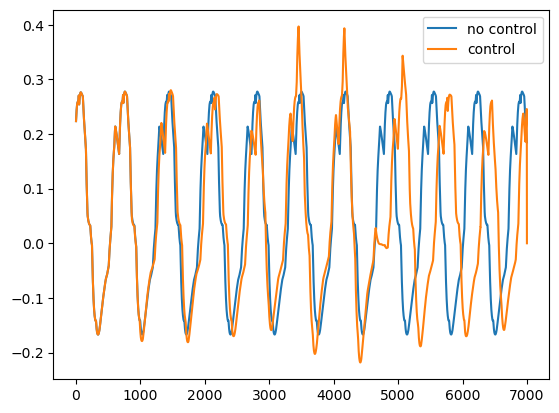

In [11]:
plt.plot(nature_no_ctrl.x0[35, :], label='no control')
plt.plot(nature_ctrl_k.x0[35, :], label='control')
plt.legend()

In [12]:
@widgets.interact(i=(0, total_duration - 2))
def img_render(i=0):
	# fig, ax = plt.subplots(1, 3, figsize=(12, 8))
	plt.subplot(1, 4, 1)
	plt.imshow(nature_ctrl_k.x0[:64, i].reshape((8, 8)))
	plt.clim(0, nature_no_ctrl.x0[:64, :].max())

	plt.subplot(1, 4, 2)
	plt.imshow(x_hat0[:64, i].reshape((8, 8)))
	plt.clim(0, nature_no_ctrl.x0[:64, i].max())
	plt.subplot(1, 4, 3)
	plt.imshow(nature_ctrl_k.y[:64, i].reshape((8, 8)))
	plt.clim(0, nature_no_ctrl.x0[:64, :].max())

	plt.subplot(1, 4, 4)
	plt.imshow(nature_no_ctrl.x0[:64, i].reshape((8, 8)))
	plt.clim(0, nature_no_ctrl.x0[:64, :].max())


interactive(children=(IntSlider(value=0, description='i', max=6998), Output()), _dom_classes=('widget-interact…

In [13]:
Pxx_tr = np.trace(Pxx0, axis1=0, axis2=1)

C:\Users\ptrso\AppData\Local\Temp\ipykernel_14056\1265832794.py:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Pxx_tr))


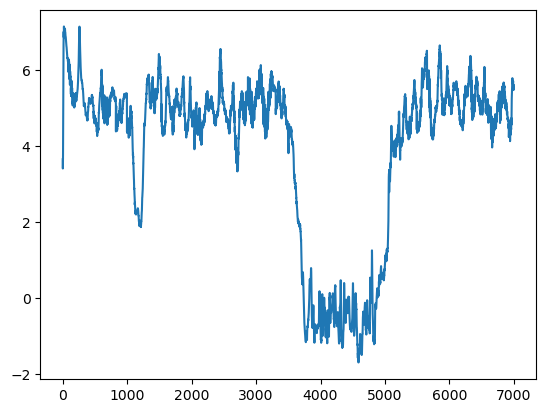

In [14]:
plt.plot(np.log(Pxx_tr))

### 2) Grid size 6 x 6

In [15]:
import numpy as np
from Assignment6 import WilsonCowanNature, WilsonCowanModelWithParameterTracking
import ukf_voss
from tqdm import tqdm
import matplotlib.pyplot as plt

# Grid size
f, g = 6, 6

# Keep the spiral wave by center-cropping original 8×8 initial conditions
u0_6x6 = u0[1:7, 1:7]
a0_6x6 = a0[1:7, 1:7]
i0_6x6 = np.concatenate((u0_6x6.ravel(), a0_6x6.ravel()))

# Initial condition check
# print("Initial condition shape:", i0_6x6.shape)
# print(i0.shape)
# print(u0.shape, u0_6x6.shape)

# Parameters
noise_factor = 1
obs_noise = 0.2  # * np.sqrt(noise_factor) # still same value
gain = -0.015
variance_inflate = 2.0
var_inflate_ukf = 40.
baseline_run = 800
total_duration = 4000  # more reasonable runtime for smaller grid size
dT = 0.01
dt = 0.001

# No control initiazation
nature_no_ctrl = WilsonCowanNature(ll=total_duration, dT=dT, dt=dt,
    f=f, g=g,
    initial_condition=i0_6x6,
    obs_noise=obs_noise, 
    run_until=total_duration-1
)

# Nature system
nature_ctrl_k = WilsonCowanNature(ll=total_duration, dT=dT, dt=dt,
    f=f, g=g,
    initial_condition=i0_6x6,
    run_until=baseline_run,
    obs_noise=obs_noise
)

# Model system
Q_par = np.array([])  # No parameter tracking yet
Q_var = variance_inflate * np.cov(nature_ctrl_k.x0[:, :baseline_run])

# Create the Wilson-Cowan model with parameter tracking
wilson_cowan_model = WilsonCowanModelWithParameterTracking(
    f=6, g=6,
    Q_par=Q_par, Q_var=Q_var,
    R=nature_ctrl_k.R)

uk_filter = ukf_voss.UKFVoss(model=wilson_cowan_model, ll=total_duration, dT=0.01, dt=0.001, variance_inflation=var_inflate_ukf)
x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=i0_6x6, run_until=baseline_run,
 												disable_progress=False)

100%|██████████| 800/800 [01:16<00:00, 10.52it/s]


In [16]:
# # Control loop
# for n in tqdm(range(baseline_run + 1, total_duration - 2)):
#     control = gain * x_hat0[:f * g, n - 1]
#     nature_ctrl_k.set_control(control)
#     wilson_cowan_model.set_control(control)
    
#     nature_ctrl_k.integrate_solveivp(run_until=n)
    
#     x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=None,
#         run_until=n, disable_progress=True)

In [17]:
for n in tqdm(range(baseline_run + 1, total_duration - 2)):
    
    nature_ctrl_k.integrate_solveivp(run_until=n)
                                     
    control = gain * x_hat0[:f * g, n - 1]
    nature_ctrl_k.set_control(control)
    wilson_cowan_model.set_control(control)
    
    x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=None,
        run_until=n, disable_progress=True)

100%|██████████| 3197/3197 [05:15<00:00, 10.12it/s]


In [18]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

@widgets.interact(i=(0, total_duration - 2))
def img_render(i=0):
    plt.figure(figsize=(12, 4))

    # True system state (with control)
    plt.subplot(1, 4, 1)
    plt.title("True x (controlled)")
    plt.imshow(nature_ctrl_k.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl.x0[:36, :].max())    
    plt.colorbar()

    # UKF estimate
    plt.subplot(1, 4, 2)
    plt.title("UKF x̂")
    plt.imshow(x_hat0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl.x0[:36, :].max())
    plt.colorbar()

    # Noisy observation
    plt.subplot(1, 4, 3)
    plt.title("Observation y")
    plt.imshow(nature_ctrl_k.y[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl.x0[:36, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title(f"No control (x0)")
    plt.imshow(nature_no_ctrl.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl.x0[:36, :].max())
    plt.colorbar()

    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

Checking the effect of smalelr gain on the 6 x 6 grid

In [21]:
import numpy as np
from Assignment6 import WilsonCowanNature, WilsonCowanModelWithParameterTracking
import ukf_voss
from tqdm import tqdm
import matplotlib.pyplot as plt

# Grid size
f, g = 6, 6

# Keep the spiral wave by center-cropping original 8×8 initial conditions
u0_6x6 = u0[1:7, 1:7]
a0_6x6 = a0[1:7, 1:7]
i0_6x6 = np.concatenate((u0_6x6.ravel(), a0_6x6.ravel()))

# Parameters
noise_factor = 1
obs_noise = 0.2  
gain = -0.0005 #  G = -0.00004 slow down G = -0.005 stop for 8x8
variance_inflate = 2.0
var_inflate_ukf = 40.
baseline_run = 800
total_duration = 4000  # more reasonable runtime for smaller grid size
dT = 0.01
dt = 0.001

# No control initiazation
nature_no_ctrl = WilsonCowanNature(ll=total_duration, dT=dT, dt=dt,
    f=f, g=g,
    initial_condition=i0_6x6,
    obs_noise=obs_noise, 
    run_until=total_duration-1
)

# Nature system
nature_ctrl_k = WilsonCowanNature(ll=total_duration, dT=dT, dt=dt,
    f=f, g=g,
    initial_condition=i0_6x6,
    run_until=baseline_run,
    obs_noise=obs_noise
)

# Model system
Q_par = np.array([])  # No parameter tracking yet
Q_var = variance_inflate * np.cov(nature_ctrl_k.x0[:, :baseline_run])

# Create the Wilson-Cowan model with parameter tracking
wilson_cowan_model = WilsonCowanModelWithParameterTracking(
    f=6, g=6,
    Q_par=Q_par, Q_var=Q_var,
    R=nature_ctrl_k.R)

uk_filter = ukf_voss.UKFVoss(model=wilson_cowan_model, ll=total_duration, dT=0.01, dt=0.001, variance_inflation=var_inflate_ukf)
x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=i0_6x6, run_until=baseline_run,
 												disable_progress=False)

100%|██████████| 800/800 [01:09<00:00, 11.44it/s]


In [22]:
for n in tqdm(range(baseline_run + 1, total_duration - 2)):
    nature_ctrl_k.integrate_solveivp(run_until=n)                              
    control = gain * x_hat0[:f * g, n - 1]
    nature_ctrl_k.set_control(control)
    wilson_cowan_model.set_control(control)
    x_hat0, Pxx0, Ks0, errors0 = uk_filter.filter(nature_ctrl_k.y, initial_condition=None,
        run_until=n, disable_progress=True)

100%|██████████| 3197/3197 [04:51<00:00, 10.97it/s]


In [23]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

@widgets.interact(i=(0, total_duration - 2))
def img_render(i=0):
    plt.figure(figsize=(12, 4))

    # True system state (with control)
    plt.subplot(1, 4, 1)
    plt.title("True x (controlled)")
    plt.imshow(nature_ctrl_k.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl.x0[:36, :].max())    
    plt.colorbar()

    # UKF estimate
    plt.subplot(1, 4, 2)
    plt.title("UKF x̂")
    plt.imshow(x_hat0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl.x0[:36, :].max())
    plt.colorbar()

    # Noisy observation
    plt.subplot(1, 4, 3)
    plt.title("Observation y")
    plt.imshow(nature_ctrl_k.y[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl.x0[:36, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title(f"No control (x0)")
    plt.imshow(nature_no_ctrl.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl.x0[:36, :].max())
    plt.colorbar()

    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

Reducing the grid from 8×8 to 6×6 almost halves complexity, but the results are not sensible in terms of preserving spiral dynamics. The waves collapse around i ≈ 100 even without control, showing the grid is too small to support meaningful spatiotemporal activity.

### 3) Initial conditions

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from Assignment6 import WilsonCowanNature

# Grid size
f = g = 8
x = np.linspace(-1, 1, f)
X, Y = np.meshgrid(x, x)

# --- 1D Gaussian Blob (along x-axis only) ---
u0_1d = np.exp(-X**2 / 0.1)
a0_1d = np.exp(-X**2 / 0.2)  # slightly wider

# --- 2D Gaussian Blob ---
u0_2d = np.exp(-(X**2 + Y**2) / 0.1)
a0_2d = np.exp(-(X**2 + Y**2) / 0.2)  # slightly wider

# Flatten into initial condition vector
i0_1d = np.concatenate((u0_1d.ravel(), a0_1d.ravel()))
i0_2d = np.concatenate((u0_2d.ravel(), a0_2d.ravel()))

# Simulation settings
dT = 0.01
dt = 0.001
total_duration = 4000
obs_noise = 0.2

# Create and run the nature system with chosen IC
nature = WilsonCowanNature(ll=total_duration,dT=dT,dt=dt,f=f,g=g,initial_condition=i0_1d, 
                           obs_noise=obs_noise,run_until=total_duration - 1)


In [113]:
import ipywidgets as widgets

@widgets.interact(i=(0, total_duration - 2))
def plot_blob_evolution(i=0):
    plt.figure(figsize=(6, 6))
    plt.title(f"True state xₜ (u-layer) at t={i}")
    plt.imshow(nature.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, 1)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

In [ ]:
# Re-run full 2D Gaussian blob setup after kernel reset

import numpy as np
import matplotlib.pyplot as plt
from Assignment6 import WilsonCowanNature, WilsonCowanModelWithParameterTracking
import ukf_voss
from tqdm import tqdm

# Grid size
f = g = 8
x = np.linspace(-1, 1, f)
X, Y = np.meshgrid(x, x)

# 2D Gaussian blob
u0 = np.exp(-(X**2 + Y**2) / 0.1)
a0 = np.exp(-(X**2 + Y**2) / 0.2)
i0 = np.concatenate((u0.ravel(), a0.ravel()))

# Simulation parameters
dT = 0.01
dt = 0.001
total_duration = 4000
baseline_run = 800
obs_noise = 0.2
gain = -0.015
# To fix big issues with y0 going to infinity we decrease
# otherwise it does not work
variance_inflate = 0.2
variance_inflation_ukf = 5.0

# No control version (reference)
nature_no_ctrl_blob = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    f=f,
    g=g,
    initial_condition=i0,
    obs_noise=obs_noise,
    run_until=total_duration - 1,
)

# Controlled system for UKF
nature_ctrl_blob = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    f=f,
    g=g,
    initial_condition=i0,
    obs_noise=obs_noise,
    run_until=baseline_run,
)

# Estimate Q_var from initial run
Q_par = np.array([])  # No parameter tracking
Q_var = variance_inflate * np.cov(nature_ctrl_blob.x0[:, :baseline_run])

# Set up model and UKF
wilson_model_blob = WilsonCowanModelWithParameterTracking(
    f=f,
    g=g,
    Q_par=Q_par,
    Q_var=Q_var,
    R=nature_ctrl_blob.R
)

ukf_blob = ukf_voss.UKFVoss(
    model=wilson_model_blob,
    ll=total_duration,
    dT=dT,
    dt=dt,
    variance_inflation=variance_inflation_ukf
)

print("Initial i0 finite?", np.all(np.isfinite(i0)))
print("Observation y finite?", np.all(np.isfinite(nature_ctrl_blob.y[:, :baseline_run])))
print("Nature x0 finite?", np.all(np.isfinite(nature_ctrl_blob.x0[:, :baseline_run])))

# Run baseline UKF
x_hat_blob, Pxx_blob, Ks_blob, errors_blob = ukf_blob.filter(
    nature_ctrl_blob.y,
    initial_condition=i0,
    run_until=baseline_run,
    disable_progress=False
)


Initial i0 finite? True
Observation y finite? True
Nature x0 finite? True


100%|██████████| 800/800 [02:42<00:00,  4.94it/s]


In [110]:
# Control loop after baseline
# for n in tqdm(range(baseline_run + 1, total_duration - 2)):
#     control = gain * x_hat_blob[:f * g, n - 1]

#     if not np.all(np.isfinite(control)):
#         print(f"[STOP] Non-finite control at n={n}")
#         break

#     nature_ctrl_blob.set_control(control)
#     wilson_model_blob.set_control(control)

    # if nature_ctrl_blob.current_time < n:
    #     nature_ctrl_blob.integrate_solveivp(run_until=n)

#     x_hat_blob, Pxx_blob, Ks_blob, errors_blob = ukf_blob.filter(
#         nature_ctrl_blob.y,
#         initial_condition=None,
#         run_until=n,
#         disable_progress=True
#     )

#     if not np.all(np.isfinite(x_hat_blob[:, n])):
#         print(f"[STOP] Kalman estimate blew up at n={n}")
#         break

for n in tqdm(range(baseline_run + 1, total_duration - 2)):
    if nature_ctrl_blob.current_time < n:
        nature_ctrl_blob.integrate_solveivp(run_until=n)
    control = gain * x_hat_blob[:f * g, n - 1]
    nature_ctrl_blob.set_control(control)
    wilson_model_blob.set_control(control)
    x_hat_blob, Pxx_blob, Ks_blob, errors_blob = ukf_blob.filter(
        nature_ctrl_blob.y,
        initial_condition=None,
        run_until=n,
        disable_progress=True
    )

100%|██████████| 3197/3197 [10:48<00:00,  4.93it/s]


In [111]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

@widgets.interact(i=(0, baseline_run - 2))
def img_render(i=0):
    plt.figure(figsize=(12, 4))

    # True system state (with control)
    plt.subplot(1, 4, 1)
    plt.title("True x (controlled)")
    plt.imshow(nature_ctrl_blob.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_blob.x0[:f*g, :].max())
    plt.colorbar()

    # UKF estimate
    plt.subplot(1, 4, 2)
    plt.title("UKF $\hat{x}$")
    plt.imshow(x_hat_blob[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_blob.x0[:f*g, :].max())
    plt.colorbar()

    # Noisy observation
    plt.subplot(1, 4, 3)
    plt.title("Observation y")
    plt.imshow(nature_ctrl_blob.y[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_blob.x0[:f*g, :].max())
    plt.colorbar()

    # Uncontrolled system
    plt.subplot(1, 4, 4)
    plt.title("No control (x0)")
    plt.imshow(nature_no_ctrl_blob.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_blob.x0[:f*g, :].max())
    plt.colorbar()


<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:17: SyntaxWarning: invalid escape sequence '\h'
C:\Users\ptrso\AppData\Local\Temp\ipykernel_14056\3439506785.py:17: SyntaxWarning: invalid escape sequence '\h'
  plt.title("UKF $\hat{x}$")


interactive(children=(IntSlider(value=0, description='i', max=798), Output()), _dom_classes=('widget-interact'…

In [114]:
# Re-import necessary modules after reset
import numpy as np
import matplotlib.pyplot as plt
from Assignment6 import WilsonCowanNature

# Grid setup
f = g = 8
dT = 0.01
dt = 0.001
total_duration = 4000
obs_noise = 0.2

# Uniform IC
u0_uniform = np.ones((f, g)) * 0.3
a0_uniform = 0.3 * u0_uniform
i0_uniform = np.concatenate((u0_uniform.ravel(), a0_uniform.ravel()))

# Run the nature model (uniform)
nature_uniform = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    f=f,
    g=g,
    initial_condition=i0_uniform,
    obs_noise=obs_noise,
    run_until=total_duration - 1,
    # z=0.2,
    # K=1.5
)

# Non-uniform IC (mild spatial randomness)
u0_random = np.random.uniform(0.2, 0.4, size=(f, g))
a0_random = 0.5 * u0_random
i0_random = np.concatenate((u0_random.ravel(), a0_random.ravel()))

nature_random = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    f=f,
    g=g,
    initial_condition=i0_random,
    obs_noise=obs_noise,
    run_until=total_duration - 1,
    # z=0.2,
    # K=1.5
)


In [117]:
import ipywidgets as widgets

@widgets.interact(i=(0, total_duration - 2))
def plot_non_uni_evolution(i=0):
    plt.figure(figsize=(6, 6))
    plt.title(f"True state xₜ (u-layer) at t={i}")
    plt.imshow(nature_random.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, 1)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

@widgets.interact(i=(0, total_duration - 2))
def plot_non_uni_evolution(i=0):
    plt.figure(figsize=(6, 6))
    plt.title(f"True state xₜ (u-layer) at t={i}")
    plt.imshow(nature_uniform.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, 1)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

In [120]:
import numpy as np
from Assignment6 import WilsonCowanNature, WilsonCowanModelWithParameterTracking
import ukf_voss

# Grid and parameters
f = g = 8
dT = 0.01
dt = 0.001
total_duration = 4000
baseline_run = 800
obs_noise = 0.2
gain = -0.015
variance_inflate = 2.0
variance_inflation_ukf = 10.0

# Non-uniform IC
u0_random = np.random.uniform(0.2, 0.4, size=(f, g))
a0_random = 0.5 * u0_random
i0_random = np.concatenate((u0_random.ravel(), a0_random.ravel()))

# Nature system without control (reference)
nature_no_ctrl_rand = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    f=f,
    g=g,
    initial_condition=i0_random,
    obs_noise=obs_noise,
    run_until=total_duration - 1
)

# Nature system with control (baseline only)
nature_ctrl_rand = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    f=f,
    g=g,
    initial_condition=i0_random,
    obs_noise=obs_noise,
    run_until=baseline_run
)

# Q matrix from baseline
Q_par = np.array([])
Q_var = variance_inflate * np.cov(nature_ctrl_rand.x0[:, :baseline_run])

# Model and UKF
model_rand = WilsonCowanModelWithParameterTracking(
    f=f,
    g=g,
    Q_par=Q_par,
    Q_var=Q_var,
    R=nature_ctrl_rand.R
)

ukf_rand = ukf_voss.UKFVoss(
    model=model_rand,
    ll=total_duration,
    dT=dT,
    dt=dt,
    variance_inflation=variance_inflation_ukf
)

# Initial Kalman filter pass
x_hat_rand, Pxx_rand, Ks_rand, errors_rand = ukf_rand.filter(
    nature_ctrl_rand.y,
    initial_condition=i0_random,
    run_until=baseline_run,
    disable_progress=False
)


100%|██████████| 800/800 [02:57<00:00,  4.51it/s]


In [ ]:
from tqdm import tqdm

for n in tqdm(range(baseline_run + 1, total_duration - 2)):
    if nature_ctrl_rand.current_time < n:
        nature_ctrl_rand.integrate_solveivp(run_until=n)
    
    control = gain * x_hat_rand[:f * g, n - 1]
    nature_ctrl_rand.set_control(control)
    model_rand.set_control(control)
    x_hat_rand, Pxx_rand, Ks_rand, errors_rand = ukf_rand.filter(
        nature_ctrl_rand.y,
        initial_condition=None,
        run_until=n,
        disable_progress=True
    )

100%|██████████| 3197/3197 [13:14<00:00,  4.02it/s]


In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

@widgets.interact(i=(0, total_duration - 2))
def plot_rand(i=0):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("True x (controlled)")
    plt.imshow(nature_ctrl_rand.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_rand.x0[:f*g, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("UKF x̂")
    plt.imshow(x_hat_rand[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_rand.x0[:f*g, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title("Observation y")
    plt.imshow(nature_ctrl_rand.y[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_rand.x0[:f*g, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("No control (ref)")
    plt.imshow(nature_no_ctrl_rand.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_rand.x0[:f*g, :].max())
    plt.colorbar()


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

The UKF is mostly either fully yellow and overstimating the state or underconfident and colapses to zero so we ened to fix the parameters gain and variance in flixation for the feedback.

In [130]:
gain = -0.0005
variance_inflation_ukf = 5.0

# Nature system without control (reference)
nature_no_ctrl_rand = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    f=f,
    g=g,
    initial_condition=i0_random,
    obs_noise=obs_noise,
    run_until=total_duration - 1
)

# Nature system with control (baseline only)
nature_ctrl_rand = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    f=f,
    g=g,
    initial_condition=i0_random,
    obs_noise=obs_noise,
    run_until=baseline_run
)

# Q matrix from baseline
Q_par = np.array([])
Q_var = variance_inflate * np.cov(nature_ctrl_rand.x0[:, :baseline_run])

# Model and UKF
model_rand = WilsonCowanModelWithParameterTracking(
    f=f,
    g=g,
    Q_par=Q_par,
    Q_var=Q_var,
    R=nature_ctrl_rand.R
)

ukf_rand = ukf_voss.UKFVoss(
    model=model_rand,
    ll=total_duration,
    dT=dT,
    dt=dt,
    variance_inflation=variance_inflation_ukf
)

# Initial Kalman filter pass
x_hat_rand, Pxx_rand, Ks_rand, errors_rand = ukf_rand.filter(
    nature_ctrl_rand.y,
    initial_condition=i0_random,
    run_until=baseline_run,
    disable_progress=False
)


100%|██████████| 800/800 [03:02<00:00,  4.39it/s]


In [131]:
from tqdm import tqdm

for n in tqdm(range(baseline_run + 1, total_duration - 2)):
    if nature_ctrl_rand.current_time < n:
        nature_ctrl_rand.integrate_solveivp(run_until=n)
    
    control = gain * x_hat_rand[:f * g, n - 1]
    nature_ctrl_rand.set_control(control)
    model_rand.set_control(control)
    x_hat_rand, Pxx_rand, Ks_rand, errors_rand = ukf_rand.filter(
        nature_ctrl_rand.y,
        initial_condition=None,
        run_until=n,
        disable_progress=True
    )

100%|██████████| 3197/3197 [13:03<00:00,  4.08it/s]


In [ ]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

@widgets.interact(i=(0, total_duration - 2))
def plot_rand(i=0):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("True x (controlled)")
    plt.imshow(nature_ctrl_rand.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_rand.x0[:f*g, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("UKF x̂")
    plt.imshow(x_hat_rand[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_rand.x0[:f*g, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title("Observation y")
    plt.imshow(nature_ctrl_rand.y[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_rand.x0[:f*g, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("No control (ref)")
    plt.imshow(nature_no_ctrl_rand.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_no_ctrl_rand.x0[:f*g, :].max())
    plt.colorbar()


interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

In [158]:
import numpy as np
from Assignment6 import WilsonCowanNature

# Parameters
dT = 0.01
dt = 0.001
total_duration = 4000
obs_noise = 0.2

# 1D Gaussian in x-direction (horizontal)
x = np.linspace(-1, 1, f)
X, Y = np.meshgrid(x, x)
u0 = 1.8 * np.exp(-X**2 / 0.1)     # Wide and strong bump
a0 = np.zeros_like(u0)            # No initial recovery

# Combine into initial condition
i0 = np.concatenate((u0.ravel(), a0.ravel()))

# Nature system only (no control, for testing)
nature_1d_wave = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    initial_condition=i0,
    obs_noise=obs_noise,
    run_until=total_duration - 1
)


In [159]:
@widgets.interact(i=(0, total_duration - 2))
def plot_1d_wave(i=0):
    plt.figure(figsize=(5, 5))
    plt.title(f"1D Gaussian Wave - Frame {i}")
    plt.imshow(nature_1d_wave.x0[:f*g, i].reshape((f, g)))
    plt.clim(0, nature_1d_wave.x0[:f*g, :].max())
    plt.colorbar()
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

In [ ]:
import numpy as np
from Assignment6 import WilsonCowanNature

# Stripe pattern: activate every other row
u0_stripes = np.zeros((8, 8))
u0_stripes[::2, :] = 1.0  # rows 0, 2, 4, 6 are fully active
a0_stripes = 0.5 * u0_stripes

# Combine into initial state vector
i0_stripes = np.concatenate((u0_stripes.ravel(), a0_stripes.ravel()))

# Run the nature system
nature_stripes = WilsonCowanNature(
    ll=4000,
    dT=0.01,
    dt=0.001,
    initial_condition=i0_stripes,
    obs_noise=0.2,
    run_until=3999
)

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

@widgets.interact(i=(0, 3999))
def plot_stripes(i=0):
    plt.figure(figsize=(5, 5))
    plt.title(f"Horizontal Stripes - Frame {i}")
    plt.imshow(nature_stripes.x0[:64, i].reshape((8, 8)))
    plt.clim(0, nature_stripes.x0[:64, :].max())
    plt.colorbar()
    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=3999), Output()), _dom_classes=('widget-interact…

In [151]:
import numpy as np
from Assignment6 import WilsonCowanNature, WilsonCowanModelWithParameterTracking
import ukf_voss

# Parameters
dT = 0.01
dt = 0.001
total_duration = 4000
baseline_run = 800
obs_noise = 0.2
gain = -0.0005
variance_inflate = 0.2
variance_inflation_ukf = 2.0

# IC: 1D Gaussian in x-direction
x = np.linspace(-1, 1, 8)
X, Y = np.meshgrid(x, x)
u0_1d = 1.8 * np.exp(-X**2 / 0.1)
a0_1d = np.zeros_like(u0_1d)
i0_1d = np.concatenate((u0_1d.ravel(), a0_1d.ravel()))

# No control (for plotting)
nature_no_ctrl_1d = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    initial_condition=i0_1d,
    obs_noise=obs_noise,
    run_until=total_duration - 1
)

# Controlled system (up to baseline)
nature_ctrl_1d = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    initial_condition=i0_1d,
    obs_noise=obs_noise,
    run_until=baseline_run
)

# Estimate Q
Q_par = np.array([])
# Q_var = variance_inflate * np.cov(nature_ctrl_1d.x0[:, :baseline_run])
Q_var = np.diag([nature_ctrl_1d.R[0, 0] * variance_inflate] * (2 * f * g))


# Model + UKF
model_1d = WilsonCowanModelWithParameterTracking(
    Q_par=Q_par,
    Q_var=Q_var,
    R=nature_ctrl_1d.R
)

ukf_1d = ukf_voss.UKFVoss(
    model=model_1d,
    ll=total_duration,
    dT=dT,
    dt=dt,
    variance_inflation=variance_inflation_ukf
)

# Initial filter
x_hat_1d, Pxx_1d, Ks_1d, errors_1d = ukf_1d.filter(
    nature_ctrl_1d.y,
    initial_condition=i0_1d,
    run_until=baseline_run,
    disable_progress=False
)

100%|██████████| 800/800 [02:48<00:00,  4.76it/s]


In [152]:
from tqdm import tqdm

for n in tqdm(range(baseline_run + 1, total_duration - 2)):
    if nature_ctrl_1d.current_time < n:
        nature_ctrl_1d.integrate_solveivp(run_until=n)
    control = gain * x_hat_1d[:64, n - 1]
    nature_ctrl_1d.set_control(control)
    model_1d.set_control(control)
    x_hat_1d, Pxx_1d, Ks_1d, errors_1d = ukf_1d.filter(
        nature_ctrl_1d.y,
        initial_condition=None,
        run_until=n,
        disable_progress=True
    )


100%|██████████| 3197/3197 [10:32<00:00,  5.06it/s]


In [153]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

@widgets.interact(i=(0, total_duration - 2))
def plot_1d_control(i=0):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("True x (controlled)")
    plt.imshow(nature_ctrl_1d.x0[:64, i].reshape((8, 8)))
    plt.clim(0, nature_no_ctrl_1d.x0[:64, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 2)
    plt.title("UKF x̂")
    plt.imshow(x_hat_1d[:64, i].reshape((8, 8)))
    plt.clim(0, nature_no_ctrl_1d.x0[:64, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.title("Observation y")
    plt.imshow(nature_ctrl_1d.y[:64, i].reshape((8, 8)))
    plt.clim(0, nature_no_ctrl_1d.x0[:64, :].max())
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.title("No control (ref)")
    plt.imshow(nature_no_ctrl_1d.x0[:64, i].reshape((8, 8)))
    plt.clim(0, nature_no_ctrl_1d.x0[:64, :].max())
    plt.colorbar()

    plt.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='i', max=3998), Output()), _dom_classes=('widget-interact…

We explored three distinct initial conditions to study different spatiotemporal behaviors in the Wilson-Cowan system. A centered 2D Gaussian blob produced a localized excitation that quickly faded (t ~ 70) due to its symmetry and overlap with recovery dynamics. A random non-uniform initial condition lasted slightly longer, generating weak, irregular spatial activity that nonetheless decayed before mid-simulation. Nevertheless, an uniformity in the activity appeared early and then interesting pattern of outward to inward "fading out" of said activity was observed.  A 1D Gaussian profile along the x-axis led to the clearest case of a linearly propagating wave, with two fronts moving outward before dissipating near the boundaries. In the 3rd and last application of IC the UKF stops giving feedback relatively early but the system survives by itself for a long time.

In all cases, wave activity was short-lived, and successful UKF tracking depended on careful tuning. As noted in the original paper, a variety of numerical strategies were necessary to stabilize the implementation, which we also had to adopt in order to prevent filter divergence (values for variance inflation might be small) and preserve sensible dynamics.

Horizontal stripes, 1D Gaussian blob and uniform conditions are also illustrated above which were a part of the process of looking for interesting behaviours to implement the Kalman filter on.

### 4) Figures recreation

In [ ]:
u0 = np.array([
    [-0.1637, -0.2244, -0.1982, -0.1410, -0.1029, -0.0811, -0.0656, -0.0396],
    [-0.2593, -0.3580, -0.3021, -0.2008, -0.1321, -0.1028, -0.0840, -0.0516],
    [-0.2444, -0.3386, -0.2746, -0.1726, -0.0950, -0.0742, -0.0637, -0.0417],
    [-0.0055, -0.0383, 0.0012, -0.0657, -0.0395, -0.0388, -0.0387, -0.0270],
    [0.2361, 0.3685, 0.2616, 0.2237, 0.0279, -0.0174, -0.0239, -0.0183],
    [0.4698, 0.7002, 0.5627, 0.2726, 0.0939, -0.0071, -0.0171, -0.0135],
    [0.3618, 0.5613, 0.4323, 0.2754, 0.0673, -0.0056, -0.0130, -0.0104],
    [0.2442, 0.2669, 0.2571, 0.1067, 0.0152, -0.0049, -0.0077, -0.0061]
])

a0 = np.array([
    [0.4104, 0.5339, 0.4345, 0.2786, 0.1904, 0.1454, 0.1157, 0.0694],
    [0.7058, 0.9183, 0.6974, 0.4049, 0.2427, 0.1821, 0.1465, 0.0893],
    [0.9263, 1.1846, 0.8515, 0.4104, 0.1757, 0.1283, 0.1085, 0.0707],
    [1.0750, 1.4204, 1.0146, 0.4695, 0.0921, 0.0646, 0.0636, 0.0444],
    [1.0367, 1.4612, 0.9507, 0.4993, 0.0532, 0.0309, 0.0380, 0.0293],
    [0.7878, 1.1079, 0.7914, 0.3707, 0.0468, 0.0205, 0.0267, 0.0213],
    [0.4156, 0.5573, 0.4218, 0.1886, 0.0255, 0.0150, 0.0202, 0.0162],
    [0.1386, 0.1823, 0.1406, 0.0437, 0.0083, 0.0090, 0.0119, 0.0095]
])
# Original initial conditions of rotating waves
i0 = np.concatenate((u0.ravel(), a0.ravel()))

In [ ]:
# Re-run setup for reproducing Figure 3 (Negative Gain, High Noise) after kernel reset

import numpy as np
from Assignment6 import WilsonCowanNature, WilsonCowanModelWithParameterTracking
import ukf_voss

# Parameters
dT = 0.01
dt = 0.001
total_duration = 4000
baseline_run = 800

# High noise level
obs_noise = 0.4
gain_fig3 = -0.0006
variance_inflate = 2.0
variance_inflation_ukf = 5.0

# Nature system: no control (for reference)
nature_no_ctrl_fig3 = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    initial_condition=i0,
    obs_noise=obs_noise,
    run_until=total_duration - 1
)

# Nature system for controlled run
nature_ctrl_fig3 = WilsonCowanNature(
    ll=total_duration,
    dT=dT,
    dt=dt,
    initial_condition=i0,
    obs_noise=obs_noise,
    run_until=baseline_run
)

# Q matrix: stable diagonal form
Q_par = np.array([])
Q_var = np.diag([nature_ctrl_fig3.R[0, 0] * variance_inflate] * (2 * f * g))

# Model + UKF
model_fig3 = WilsonCowanModelWithParameterTracking(
    Q_par=Q_par,
    Q_var=Q_var,
    R=nature_ctrl_fig3.R
)

ukf_fig3 = ukf_voss.UKFVoss(
    model=model_fig3,
    ll=total_duration,
    dT=dT,
    dt=dt,
    variance_inflation=variance_inflation_ukf
)

# Initial filter
x_hat_fig3, Pxx_fig3, Ks_fig3, errors_fig3 = ukf_fig3.filter(
    nature_ctrl_fig3.y,
    initial_condition=i0,
    run_until=baseline_run,
    disable_progress=False
)

100%|██████████| 800/800 [02:44<00:00,  4.88it/s]


In [ ]:
from tqdm import tqdm

for n in tqdm(range(baseline_run + 1, total_duration - 2)):
    if nature_ctrl_fig3.current_time < n:
        nature_ctrl_fig3.integrate_solveivp(run_until=n)

    control = gain_fig3 * x_hat_fig3[:f * g, n - 1]

    if not np.all(np.isfinite(control)):
        print(f"[STOP] Non-finite control at n={n}")
        break

    nature_ctrl_fig3.set_control(control)
    model_fig3.set_control(control)

    x_hat_fig3, Pxx_fig3, Ks_fig3, errors_fig3 = ukf_fig3.filter(
        nature_ctrl_fig3.y,
        initial_condition=None,
        run_until=n,
        disable_progress=True
    )

 30%|██▉       | 951/3197 [03:27<07:42,  4.85it/s]